## Multi label text classification using Bi-LSTM NNs
This notebook can be uploaded to Google colab and run it as it is. It will clone the project and get into the apporiate directory to train and predict

### Check if target machine is colab
#### In case it is on colab clone project

In [1]:
try:
    import google.colab
    RunningInCOLAB = True
except:
    RunningInCOLAB = False

if RunningInCOLAB:
    from getpass import getpass
    import urllib

    user = input('User name: ')
    password = getpass('Password: ')
    password = urllib.parse.quote(password) # your password is converted into url format
    AUTHENTICATION = '{}:{}'.format(user, password)

    !git clone https://$AUTHENTICATION@github.com/georgSquared/AdvancedML-Auth.git
    AUTHENTICATION = '' # remove authentication variable
    
    %cd AdvancedML-Auth/src/aml-auth

User name: ZisisFl
Password: ··········
Cloning into 'AdvancedML-Auth'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 403 (delta 211), reused 285 (delta 109), pack-reused 0
Receiving objects: 100% (403/403), 7.45 MiB | 17.91 MiB/s, done.
Resolving deltas: 100% (211/211), done.
/content/AdvancedML-Auth/src/aml-auth


### Import libraries

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

from data_processing import get_fully_processed, get_selected_genres
from evaluation import evaluate_model, evaluate_per_label

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load data

In [4]:
books_df, genres_to_predict = get_fully_processed(genres_list=get_selected_genres(), multilabel=True)
books = books_df['book_description_processed'].values
labels = books_df[genres_to_predict].values

print('{} books with {} labels'.format(labels.shape[0], labels.shape[1]))

12458 books with 9 labels


### Prepare sequences for training

In [5]:
# tokenize book descriptions with tensorflow's tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(books)

# create sequences out of book descriptions
sequences = tokenizer.texts_to_sequences(books)

# get maximum book description length in order to pad sequences to that length
max_length = max([len(s.split()) for s in books])

# define vocab size
word_index = tokenizer.word_index
vocabulary_size = len(word_index)
print('Found %s unique tokens.' % vocabulary_size)

# pad sequences
data = pad_sequences(sequences, maxlen=max_length, padding='post')

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 45305 unique tokens.
Shape of data tensor: (12458, 768)
Shape of label tensor: (12458, 9)


### Split train test sets

In [6]:
indices = np.arange(data.shape[0])

# shuffle indices
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# number of validation samples
validation_samples = int(0.25 * data.shape[0])

# split to train and test sets
x_train = data[:-validation_samples]
y_train = labels[:-validation_samples]
x_val = data[-validation_samples:]
y_val = labels[-validation_samples:]

print("Train Shapes - X: {} - Y: {}".format(x_train.shape, y_train.shape))
print("Val Shapes - X: {} - Y: {}".format(x_val.shape, y_val.shape))

Train Shapes - X: (9344, 768) - Y: (9344, 9)
Val Shapes - X: (3114, 768) - Y: (3114, 9)


In [26]:
def plot_training_history(history):
    # summarize history for hamming_loss
    plt.figure(figsize=(16,8))
    plt.plot(history.history['hamming_loss'])
    plt.plot(history.history['val_hamming_loss'])
    plt.title('model hamming_loss')
    plt.ylabel('hamming_loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Model

In [27]:
# set up early stopping callback
callback = EarlyStopping(monitor='loss', patience=2)

# init hamming loss a metric
hl = tfa.metrics.HammingLoss(mode='multilabel', threshold=0.8)

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size+1,
                        output_dim=100,
                        input_length=max_length))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.4))
    model.add(Dense(len(genres_to_predict), activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[hl])
    model.summary()

    history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 768, 100)          4530600   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1809      
Total params: 4,693,209
Trainable params: 4,693,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
292/292 [==============================] - 28s 87ms/step - loss: 0.4916 - hamming_loss: 0.2342 - val_loss: 0.4310 - val_hamming_loss: 0.2237
Epoch 2/20
292/292 [==============================] - 41s 141ms/step - loss: 0.3920 - hamm

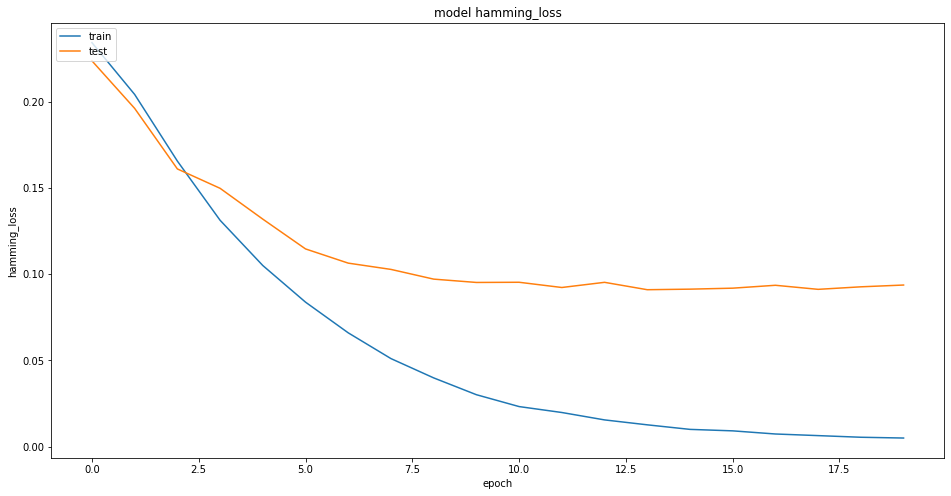

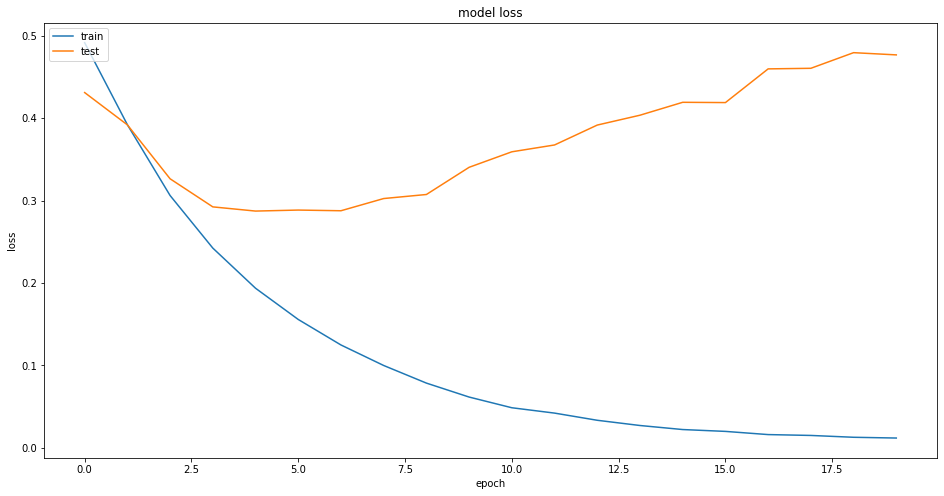

In [28]:
plot_training_history(history)

### Predict and evaluate

In [29]:
# get predictions
y_pred = model.predict(x_val)

# round probabilities to get vector of labels
y_pred = y_pred.round()

# evaluate model
evaluate_model(y_val, y_pred, print_results=True);

#evaluate_per_label(pd.DataFrame(y_val), y_pred, print_results=True)

Accuracy score: 0.5385
Precision score: 0.7945 with average parameter: micro
Recall score: 0.7985 with average parameter: micro
F1 score: 0.7965 with average parameter: micro
Hamming loss: 0.0972
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1110
           1       0.70      0.77      0.73      1026
           2       0.81      0.83      0.82       964
           3       0.88      0.87      0.88       806
           4       0.76      0.83      0.80       644
           5       0.67      0.68      0.68       582
           6       0.72      0.77      0.74       532
           7       0.79      0.80      0.80       525
           8       0.87      0.79      0.83       486

   micro avg       0.79      0.80      0.80      6675
   macro avg       0.79      0.79      0.79      6675
weighted avg       0.80      0.80      0.80      6675
 samples avg       0.79      0.80      0.77      6675



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
